## Quick Recap:
RNA-Seq is a powerful method used in molecular biology to study gene expression. It is a technique that allows scientists to measure the amount of RNA molecules produced by cells or tissues under different conditions.

To understand RNA-Seq, we first need to know what RNA is. RNA stands for Ribonucleic Acid, and it is a molecule that plays an important role in the process of gene expression. RNA acts as a messenger between DNA (the genetic material of the cell) and proteins (the functional molecules that perform many tasks in the cell).

RNA-Seq works by isolating RNA from cells or tissues and converting it into a complementary DNA (cDNA) library. This cDNA library is then sequenced using high-throughput sequencing technologies, which generate millions of short reads that represent the RNA molecules present in the sample.

Once the reads are generated, bioinformaticians use specialized software to analyze them and map them back to the genome or transcriptome of the organism being studied. This mapping step allows scientists to identify which genes are expressed in the sample and how much RNA is being produced by each gene.

RNA-Seq can provide insights into a variety of biological processes, such as gene regulation, cellular differentiation, and disease states. It has revolutionized the field of molecular biology and is now widely used in research labs around the world.

## Scenario (Exemplary):

We started by obtaining raw sequencing reads in .fastq format from the sequencing facility. Before analyzing the data, we performed Quality Control (QC) checks to ensure the quality of the reads. These checks included assessing the distribution of read lengths, looking for the presence of adapter sequences, and checking for the presence of any low-quality reads.

Once we were satisfied with the quality of the reads, we used software such as STAR to map the reads to a transcriptome. We then used software such as SALMON to quantify the expression levels of each transcript, which gave us the number of reads that mapped to each transcript in the transcriptome, and then we used transcript counts to aggregate to gene level expression.

Now, our data consists of gene level counts for each sample, and we are expected to analyze it.

## We will do the following:

**Firstly**, to get a quick overview of the samples, we will use a technique called Principal Component Analysis (PCA). This technique allows us to visualize the similarities and differences between the samples based on their gene expression profiles. It was a useful way to check if the samples clustered together based on the expected biological variables (e.g., organ type or treatment condition).

**Next**, we want to compare gene expression between different conditions, such as different organs or treatment conditions. To do this, we use a statistical method called differential gene expression analysis. This method compares the expression of each gene between two or more conditions and identified genes that were expressed differently. We used software such as DESeq2 to perform differential gene expression analysis.

**Finally**, once we have identified the differentially expressed genes, we wante to understand which biological pathways or processes were affected. We do this using gene set enrichment analysis, which compared the differentially expressed genes to known sets of genes involved in specific biological pathways or processes. We use software such as EnrichR or GSEA to perform gene set enrichment analysis.

## Info on data:

Sequencing libraries are created from total extracted mRNAs from different organs of healthy mice, after Cisplatin treatment or kept untreated.

## Info on condition:

Cisplatin is a chemotherapy drug commonly used to treat various types of cancer. It works by binding to DNA molecules in cancer cells and causing damage to the DNA strands. The damage caused by cisplatin can activate the cell's DNA repair mechanisms, including nucleotide excision repair (NER).

Nucleotide excision repair is a DNA repair mechanism that removes and replaces damaged nucleotides (the building blocks of DNA) in the DNA strand. NER is a multi-step process that involves the recognition and removal of damaged DNA, followed by the insertion of new nucleotides to repair the damage.

In the case of cisplatin treatment, the drug causes a specific type of DNA damage known as DNA crosslinking, where the two strands of DNA are covalently linked together. This type of DNA damage is particularly toxic and can lead to cell death if left unrepaired. NER plays a critical role in repairing this type of damage caused by cisplatin.

However, cancer cells can also develop resistance to cisplatin by altering their DNA repair mechanisms, including NER. Some cancer cells may overexpress certain proteins involved in NER, allowing them to repair the DNA damage caused by cisplatin more efficiently and survive the treatment.

Overall, the relationship between cisplatin and NER is complex and can have significant implications for the effectiveness of cisplatin chemotherapy in treating cancer. Understanding this relationship is important for developing new strategies to overcome cisplatin resistance and improve cancer treatment outcomes.

[RNA-seq Dataset Info](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE117167)

The modules we are going to use are as followed:
1. PyDESeq2: is for Differential gene expression analysis. It is Python implementation of DESeq2 library which is originally in R.
2. GSEApy: is a Python/Rust implementation of GSEA and wrapper for Enrichr. Enrichr contains most comprehensive and popular gene set libraries. We are going to use it for gene set enrichment over the selected libraries to see which biological pathways are enriched on up-regulated and down-regulated gene sets.

In [ ]:
# After installing the below modules, dont forget to restart the runtime, as it needs to change the modules which the versions are changed.
!pip install --quiet numpy==1.23.0 pydeseq2 gseapy dash-bio

In [ ]:
import pandas as pd
import numpy as np
import copy
np.seterr(all="ignore")

# DGE and Pathway Enrichment
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
from gseapy import Biomart

# PCA
from sklearn.decomposition import PCA

# Viz.
import plotly.express as px
import dash_bio
from gseapy import dotplot

The following are helper functions for visualizations that are in DESeq2 but not in PyDESeq2 such as: Run PCA/plot, Volcano Plot, Dispersion Plot, MA Plot.


In [ ]:
def plotPCA(dds, clinical_df, nTop=0, vst=True, returnData=False):

  if vst:
    counts = dds.layers['vst_counts']
  else:
    counts = dds.layers['normed_counts']

  colwise_var = np.var(counts, axis=0)
  idx = np.argpartition(colwise_var, -nTop)[-nTop:] if nTop > 0 else (-colwise_var).argsort()[:]

  pca = PCA(n_components=3)
  pca_data = pca.fit_transform(counts[:, idx])
  print(f'Explained Variance Ratio :{sum(pca.explained_variance_ratio_)}')

  index_to_use = dds.obsm['design_matrix'].index
  pca_df = pd.DataFrame(
      {'pc1': pca_data[:,0],
       'pc2': pca_data[:,1],
       'pc3': pca_data[:,2],
       'organ': clinical_df.loc[index_to_use]['organ'],
       'condition': clinical_df.loc[index_to_use]['condition']})

  fig = px.scatter_3d(pca_df, x='pc1', y='pc2', z='pc3',
                    color='organ', symbol='condition')
  fig.show()

  if returnData:
    return pca, pca_data

def plotVolcano(stat_res, lfc_thr=[-1, 1], padj_thr=0.05):
  res_df = stat_res.results_df

  plot_df = res_df.dropna()
  plot_df = pd.DataFrame({
      'EFFECTSIZE': np.array(plot_df['log2FoldChange']).astype(float),
      'P': np.array(plot_df['padj']).astype(float),
      'GENE': list(plot_df.index)})

  fig = dash_bio.VolcanoPlot(
      dataframe=plot_df,
      snp=None,
      genomewideline_value=-np.log10(padj_thr),
      effect_size_line=lfc_thr,
      ylabel='-log10(Adjusted p-value)',
      xlabel='Effect Size: log2(fold-change)')

  fig.show()

def plotDispEsts(dds):
  gene_est = list(np.log(dds.varm['genewise_dispersions']))
  fit = list(np.log(dds.varm['fitted_dispersions']))
  final = list(np.log(dds.varm['dispersions']))
  n = len(gene_est)

  m_norm_counts = list(np.log(np.average(dds.layers['normed_counts'], axis=0)))

  plot_df = pd.DataFrame({
      'dispersion': gene_est + fit + final,
      'name': ['Genewise Dispersions'] * n + ['Fitted Dispersions'] * n + ['Final Dispersions'] * n,
      'mean_norm_counts': m_norm_counts * 3
  })

  fig = px.scatter(plot_df, y = 'dispersion', x = 'mean_norm_counts', color = 'name', opacity=0.8)
  fig.show()

def plotMA(stat_res, padj_thr=0.05):
  dds = stat_res.dds
  res_df = stat_res.results_df

  colors = ['sig' if float(padj) <= padj_thr else 'non-sig' for padj in list(res_df['padj'])]
  l2fc =list(res_df['log2FoldChange'])

  m_norm_counts = np.log10(np.average(dds.layers['normed_counts'], axis=0))

  plot_df = pd.DataFrame({
      'padj Significance': colors,
      'log2 Fold-Change': l2fc,
      'log10 (Mean of Normalized Counts Per Gene)': m_norm_counts
  })

  fig = px.scatter(plot_df, y = 'log2 Fold-Change', x = 'log10 (Mean of Normalized Counts Per Gene)', color = 'padj Significance')
  fig.show()

In [ ]:
clinical_df = pd.read_csv('/content/clinical.tsv', sep='\t')
clinical_df = clinical_df.set_index('sampleID')
clinical_df = clinical_df.sort_index(ascending=True)

counts_df = pd.read_csv('/content/counts.tsv', sep='\t')
counts_df = counts_df.set_index('geneIDs')
counts_df = counts_df.T.loc[clinical_df.index]
counts_df = counts_df.sort_index(ascending=True)

In [ ]:
print(clinical_df)
print(counts_df)

             organ condition
sampleID                    
GSM3272779  kidney     untrt
GSM3272780  kidney       cis
GSM3272781  kidney     untrt
GSM3272782  kidney       cis
GSM3272787    lung       cis
GSM3272788    lung     untrt
GSM3272789    lung       cis
GSM3272790    lung     untrt
geneIDs     ENSMUSG00000102693  ENSMUSG00000051951  ENSMUSG00000025900  \
sampleID                                                                 
GSM3272779                   0                   8                  33   
GSM3272780                   0                   2                  10   
GSM3272781                   0                   4                  46   
GSM3272782                   0                   2                  26   
GSM3272787                   0                  15                 723   
GSM3272788                   2                  23                 571   
GSM3272789                   0                  43                3694   
GSM3272790                   0              


clinical_df:

The index of this dataframe represents the sample IDs.
It has two columns: "organ" and "condition".
The "organ" column contains information about the organ from which each sample was taken.
The "condition" column contains information about the treatment condition of each sample.
The dataframe has 8 rows, indicating that there are 8 samples in total.



counts_df:

The index of this dataframe represents the sample IDs, matching the samples in the clinical_df dataframe.
The columns of this dataframe represent gene IDs.
The values in the dataframe represent the gene-level counts for each sample and gene.
Each row corresponds to a specific sample, and each column corresponds to a specific gene.
The dataframe has 8 rows (matching the number of samples) and 25059 columns (representing different genes).






In [ ]:
#Filter out genes that have less than 10 counts across samples
counts_df = counts_df.loc[:, counts_df.sum() >= 10]
print(counts_df)

geneIDs     ENSMUSG00000051951  ENSMUSG00000025900  ENSMUSG00000025902  \
sampleID                                                                 
GSM3272779                   8                  33                 326   
GSM3272780                   2                  10                 242   
GSM3272781                   4                  46                 415   
GSM3272782                   2                  26                 504   
GSM3272787                  15                 723                2509   
GSM3272788                  23                 571                 924   
GSM3272789                  43                3694                5638   
GSM3272790                  45                1557                2398   

geneIDs     ENSMUSG00000033845  ENSMUSG00000025903  ENSMUSG00000033813  \
sampleID                                                                 
GSM3272779                 818                6979                1119   
GSM3272780                 684       

We are going to create DeseqDataSet object from your counts_df and clinical_df. DeseqDataSet object contains the methods for DESeq2 workflow and necessary transformations.

[link](https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_minimal_pydeseq2_pipeline.html#sphx-glr-auto-examples-plot-minimal-pydeseq2-pipeline-py)



In [ ]:
# Create DESeq Dataset object and assign it to dds_all
dds_all = DeseqDataSet(
    counts=counts_df,
    clinical=clinical_df,
    design_factors="condition",
    refit_cooks=True,
    n_cpus=8,
)

DeseqDataSet object contains a method for Variance Stabilizing Transformation (vst). We will apply it to dds_all. We need this method to transform normalized counts, so that we can perform PCA.

In [ ]:
# Perform Variance Stabilizing Transformation (vst) on dds_all
dds_all = dds_all.vst()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 59.88 seconds.

Fitting dispersion trend curve...
... done in 9.58 seconds.



In [ ]:
kidney_samples = clinical_df[clinical_df['organ'] == 'kidney'] # Filter clinical df for kidney
filtered_counts_df = counts_df.loc[kidney_samples.index] # Filter counts_df for kidney
dds = DeseqDataSet (
    counts=filtered_counts_df,
    clinical=kidney_samples,
    design_factors="condition",
    ref_level= ["condition", "untrt"],
    refit_cooks=True,
    n_cpus=8
) #Create a New DeseqDataset object with the filtered dataframes


In [ ]:
# Run DESeq2 workflow to Perform dispersion and log fold-change (LFC) estimation.
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 24.74 seconds.

Fitting dispersion trend curve...
... done in 7.80 seconds.

Fitting MAP dispersions...
... done in 24.67 seconds.

Fitting LFCs...
... done in 17.54 seconds.

Refitting 0 outliers.



In [ ]:
# Plot dispersions
plotDispEsts(dds)


Based on the dispersion plot, we observe that the dispersion estimates in the DESeq2 model show a gradual decrease from around 4 at a mean normalized count of -2 to approximately -3 at a mean normalized count of 13. This pattern suggests that the variability in gene expression levels is well-captured by the model, as the dispersion estimates remain relatively stable across a range of mean expression levels. However, it is worth noting that there are some outliers present in the plot, particularly in the mean normalized count range of 1 to 3. These outliers indicate genes with higher-than-expected variability in expression, which might be due to specific biological factors or technical artifacts. Despite the presence of outliers, the majority of genes exhibit consistent dispersion estimates. Considering these observations, it can be concluded that the data generally fits well with the DESeq2 model, as the dispersion estimates show stability and no obvious systematic patterns. However, further analysis and exploration of these outliers may be necessary to better understand their impact on the overall model fit and biological interpretation of the data.

In [ ]:
# # Run this cell for the statistical tests for differential expression and lfc shrink
stat_res = DeseqStats(dds)
stat_res.summary()
stat_res_unshrunken = copy.deepcopy(stat_res)
# Shrink lfc
stat_res.lfc_shrink(coeff="condition_cis_vs_untrt")

Running Wald tests...
... done in 7.31 seconds.

Log2 fold change & Wald test p-value: condition cis vs untrt


baseMean  log2FoldChange     lfcSE      stat    pvalue  \
geneIDs                                                                         
ENSMUSG00000051951     4.787864       -1.540114  1.871261 -0.823035  0.410488   
ENSMUSG00000025900    27.482929       -1.091566  0.800964 -1.362816  0.172941   
ENSMUSG00000025902   372.726947        0.112620  0.386799  0.291158  0.770931   
ENSMUSG00000033845  1305.441887        0.098559  0.245856  0.400883  0.688506   
ENSMUSG00000025903  8925.549510       -0.107628  0.236150 -0.455761  0.648562   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000063698   122.328957       -0.633687  0.419281 -1.511365  0.130696   
ENSMUSG00000024997  7765.231644        0.099096  0.225262  0.439914  0.659999   
ENSMUSG00000003228   262.902565       -0.586596  0.342973 -1.710329  0.087205   
ENSMUSG00000074733   619.804278       -0.126400  0.462788 -0.273128  0.784755   
ENSMUSG00000059326   303.643847        0.475021  0.400807  1.185159  0.235955   

                        padj  
geneIDs                       
ENSMUSG00000051951       NaN  
ENSMUSG00000025900  0.413566  
ENSMUSG00000025902  0.907714  
ENSMUSG00000033845  0.865152  
ENSMUSG00000025903  0.842518  
...                      ...  
ENSMUSG00000063698  0.345787  
ENSMUSG00000024997  0.849443  
ENSMUSG00000003228  0.262719  
ENSMUSG00000074733  0.913579  
ENSMUSG00000059326  0.499617  

[19887 rows x 6 columns]

Fitting MAP LFCs...
... done in 31.79 seconds.

Shrunk Log2 fold change & Wald test p-value: condition cis vs untrt


baseMean  log2FoldChange     lfcSE      stat    pvalue  \
geneIDs                                                                         
ENSMUSG00000051951     4.787864       -0.073159  0.511825 -0.823035  0.410488   
ENSMUSG00000025900    27.482929       -0.278483  0.550325 -1.362816  0.172941   
ENSMUSG00000025902   372.726947        0.063210  0.329614  0.291158  0.770931   
ENSMUSG00000033845  1305.441887        0.073556  0.228835  0.400883  0.688506   
ENSMUSG00000025903  8925.549510       -0.117506  0.221839 -0.455761  0.648562   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000063698   122.328957       -0.376374  0.387912 -1.511365  0.130696   
ENSMUSG00000024997  7765.231644        0.073381  0.212483  0.439914  0.659999   
ENSMUSG00000003228   262.902565       -0.407936  0.328370 -1.710329  0.087205   
ENSMUSG00000074733   619.804278       -0.060650  0.369790 -0.273128  0.784755   
ENSMUSG00000059326   303.643847        0.278369  0.364540  1.185159  0.235955   

                        padj  
geneIDs                       
ENSMUSG00000051951       NaN  
ENSMUSG00000025900  0.413566  
ENSMUSG00000025902  0.907714  
ENSMUSG00000033845  0.865152  
ENSMUSG00000025903  0.842518  
...                      ...  
ENSMUSG00000063698  0.345787  
ENSMUSG00000024997  0.849443  
ENSMUSG00000003228  0.262719  
ENSMUSG00000074733  0.913579  
ENSMUSG00000059326  0.499617  

[19887 rows x 6 columns]

In [ ]:
#MA Plot for shrunken lfc
plotMA(stat_res, padj_thr=0.05)
#MA Plot for unshrunken lfc
plotMA(stat_res_unshrunken, padj_thr=0.05)


The MA plot for the shrunken log2 fold change (lfc) shows that the majority of genes have log2 fold changes between -1 and 1. This indicates that after applying the lfc shrinkage method, the estimated fold changes are moderated towards zero, resulting in a narrower range of fold changes. The plot appears to be more concentrated around zero, suggesting that the shrinkage has reduced the extreme fold change values and brought them closer to the baseline. Additionally, the MA plot for the shrunken lfc shows a symmetrical distribution horizontally, indicating that the upregulated and downregulated genes are balanced.

On the other hand, the MA plot for the unshrunken lfc exhibits a wider range of log2 fold changes, spanning from approximately -7 to 7. This wider range indicates that the unshrunken lfc estimates have not been moderated or adjusted, resulting in more extreme fold change values. The plot also contains outliers, which are genes with highly exaggerated fold changes. Furthermore, unlike the shrunken lfc plot, the distribution of points in the unshrunken lfc plot appears to be less symmetrical horizontally, suggesting a potential bias towards either upregulated or downregulated genes.

The difference between the two plots reflects the impact of lfc shrinkage in reducing the variability and extreme values in the fold change estimates. The shrunken lfc plot demonstrates a more conservative and moderated view of the fold changes, providing a more reliable representation of the differential expression between conditions. In contrast, the unshrunken lfc plot displays a wider range of fold changes, including both highly significant and potentially less reliable estimates. Therefore, the use of lfc shrinkage helps to mitigate the influence of outliers and provides a more balanced and interpretable view of differential gene expression.

Volcano plot is a great way to get an overall picture of what is going on, where we plot the log transformed adjusted p-values plotted on the y-axis and log2 fold change values on the x-axis.

In [ ]:
#Volcano Plot
plotVolcano(stat_res)

In [ ]:
res_df = stat_res.results_df
res_df

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
geneIDs                                                                         
ENSMUSG00000051951     4.787864       -0.073159  0.511825 -0.823035  0.410488   
ENSMUSG00000025900    27.482929       -0.278483  0.550325 -1.362816  0.172941   
ENSMUSG00000025902   372.726947        0.063210  0.329614  0.291158  0.770931   
ENSMUSG00000033845  1305.441887        0.073556  0.228835  0.400883  0.688506   
ENSMUSG00000025903  8925.549510       -0.117506  0.221839 -0.455761  0.648562   
...                         ...             ...       ...       ...       ...   
ENSMUSG00000063698   122.328957       -0.376374  0.387912 -1.511365  0.130696   
ENSMUSG00000024997  7765.231644        0.073381  0.212483  0.439914  0.659999   
ENSMUSG00000003228   262.902565       -0.407936  0.328370 -1.710329  0.087205   
ENSMUSG00000074733   619.804278       -0.060650  0.369790 -0.273128  0.784755   
ENSMUSG00000059326   303.643847        0.278369  0.364540  1.185159  0.235955   

                        padj  
geneIDs                       
ENSMUSG00000051951       NaN  
ENSMUSG00000025900  0.413566  
ENSMUSG00000025902  0.907714  
ENSMUSG00000033845  0.865152  
ENSMUSG00000025903  0.842518  
...                      ...  
ENSMUSG00000063698  0.345787  
ENSMUSG00000024997  0.849443  
ENSMUSG00000003228  0.262719  
ENSMUSG00000074733  0.913579  
ENSMUSG00000059326  0.499617  

[19887 rows x 6 columns]


Fold change refers to the ratio of expression levels between two conditions or groups. It represents the magnitude of change in gene expression. A fold change of 1 indicates no change, while a fold change greater than 1 indicates upregulation (increase in expression) and a fold change less than 1 indicates downregulation (decrease in expression). For example, a fold change of 2 means the gene expression has doubled, while a fold change of 0.5 means the gene expression has been reduced to half.

The p-value represents the probability of obtaining a result as extreme as or more extreme than the observed result, assuming the null hypothesis is true. In the context of differential expression analysis, the p-value indicates the likelihood of observing the observed fold change between conditions by chance alone, assuming no true difference in gene expression. A smaller p-value suggests stronger evidence against the null hypothesis and indicates a higher degree of statistical significance.

The adjusted p-value (padj) is a modified version of the p-value that accounts for multiple hypothesis testing. Multiple test correction methods, such as the Benjamini-Hochberg procedure, are used to adjust p-values to control the false discovery rate (FDR). The FDR is the expected proportion of false positives among all the genes declared as differentially expressed. The padj represents the corrected or adjusted p-value, taking into account the number of tests performed.




In [ ]:
# Filter res_df for statistically significant genes
significant_degs = res_df[res_df['padj'] <= 0.05]

# filter the genes based on log2FC and Adjusted p-value, where log 2 folc change
up_degs = res_df[res_df['log2FoldChange'] >= 1]
down_degs = res_df[res_df['log2FoldChange'] <= -1]

After obtaining gene sets of upregulated and downregulated genes, we will perform gene set enrichment, with EnrichR api inside GSEApy. EnrichR needs Entrez Gene names instead of Ensembl gene ids. We can think of it as different databases name genes differently.

In [ ]:
# Convert ensembl gene ids to Entrez Gene Names using biomart api inside gseapy via batch submission

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def batch_subs(degs, n=20):
  bm = Biomart()

  gene_names = []
  for batch in chunks(degs, n):

    queries ={'ensembl_gene_id': batch }
    results = bm.query(dataset='mmusculus_gene_ensembl',
                      attributes=['entrezgene_accession'],
                      filters=queries)
    gene_names += list(results['entrezgene_accession'])

  return [i.upper() for i in gene_names]

gene_names_down = batch_subs(down_degs.index)
gene_names_up = batch_subs(up_degs.index)

In [ ]:
# Check out libraries that are present for Mouse
gp.get_library_name(organism='Mouse')

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisGeNET',
 'Disease_


The Gene Ontology (GO) database is a widely used bioinformatics resource that provides a standardized vocabulary to annotate gene products in terms of their molecular function, cellular component, and biological process. It is organized into three major ontologies:

Molecular Function: This ontology describes the activities or tasks performed by gene products at the molecular level. It includes terms such as binding, catalysis, or receptor activity.

Cellular Component: This ontology represents the locations or structures within a cell where gene products are active. It includes terms such as nucleus, mitochondrion, or cytoskeleton.

Biological Process: This ontology describes the biological goals or objectives that gene products contribute to. It includes terms such as cell division, immune response, or signal transduction.

These three ontologies together provide a comprehensive framework to annotate and understand the functions and roles of genes and gene products.

The KEGG (Kyoto Encyclopedia of Genes and Genomes) pathway database is a collection of manually curated pathway maps that represent molecular interaction and reaction networks. It provides information about various biological pathways and their associated genes and molecules. KEGG pathways help in understanding the complex interactions and functions of genes in different biological processes, such as metabolic pathways, signaling pathways, and disease pathways.

In [ ]:
# Up-regulated genes, cis vs untrt
enr_up = gp.enrichr(gene_list=gene_names_up,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='mouse',
                 outdir=None,
                )
enr_res_up = enr_up.results

enr_res_up.loc[enr_res_up['Adjusted P-value'] < .05]

Gene_set  \
0    GO_Biological_Process_2021   
1    GO_Biological_Process_2021   
2    GO_Biological_Process_2021   
3    GO_Biological_Process_2021   
4    GO_Biological_Process_2021   
..                          ...   
158  GO_Biological_Process_2021   
159  GO_Biological_Process_2021   
160  GO_Biological_Process_2021   
161  GO_Biological_Process_2021   
162  GO_Biological_Process_2021   

                                                  Term Overlap       P-value  \
0            response to unfolded protein (GO:0006986)   14/49  2.894229e-11   
1    positive regulation of apoptotic process (GO:0...  32/310  1.116321e-10   
2         regulation of apoptotic process (GO:0042981)  53/742  1.520317e-10   
3    regulation of cell population proliferation (G...  50/764  9.622006e-09   
4    negative regulation of transcription by RNA po...  46/684  1.712170e-08   
..                                                 ...     ...           ...   
158           regulation of lipid storage (GO:0010883)    4/22  2.681624e-03   
159  positive regulation of macromolecule biosynthe...  10/129  2.789768e-03   
160  positive regulation of cell population prolife...  24/474  2.797494e-03   
161  regulation of mesenchymal cell proliferation (...    3/11  2.805232e-03   
162  negative regulation of oxidative stress-induce...    3/11  2.805232e-03   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0        8.112523e-08            0                     0   14.657358   
1        1.420483e-07            0                     0    4.311601   
2        1.420483e-07            0                     0    2.940154   
3        6.742621e-06            0                     0    2.656812   
4        8.838490e-06            0                     0    2.724465   
..                ...          ...                   ...         ...   
158      4.727416e-02            0                     0    7.999177   
159      4.823966e-02            0                     0    3.042992   
160      4.823966e-02            0                     0    1.949333   
161      4.823966e-02            0                     0   13.480591   
162      4.823966e-02            0                     0   13.480591   

     Combined Score                                              Genes  
0        355.671318  HSP90AA1;HSP90AB1;HSPB7;HSPB1;HSPA2;DNAJB2;DNA...  
1         98.803832  USP27X;BCL10;FGD3;ZC3H12A;PMAIP1;PHLDA1;SOX4;P...  
2         66.467852  SCX;SRA1;HSPB1;MYC;PIM2;SOX9;PHLDA1;SOX4;PHLDA...  
3         49.042653  BTG2;CDKN1A;HILPDA;SCX;CXCL1;TCIRG1;ADAMTS1;MY...  
4         48.721392  CEBPB;BHLHE41;ZBTB21;CREM;BACH1;RELA;ETS2;DNAJ...  
..              ...                                                ...  
158       47.365790                        NFKBIA;HILPDA;ZC3H12A;SIRT1  
159       17.898263  RBM3;YTHDF1;PCNA;EIF6;MYC;CIRBP;NMD3;KLF4;SIRT...  
160       11.460191  CDKN1A;SPHK1;HILPDA;NOP2;FZD9;LIF;SCX;PDGFA;TC...  
161       79.215584                                     MYC;PDGFA;SOX9  
162       79.215584                                    REST;NR4A3;ATF4  

[163 rows x 10 columns]

<Axes: title={'center': 'UP Genes - GO_Biological_Process_2021'}, xlabel='Combined Score'>

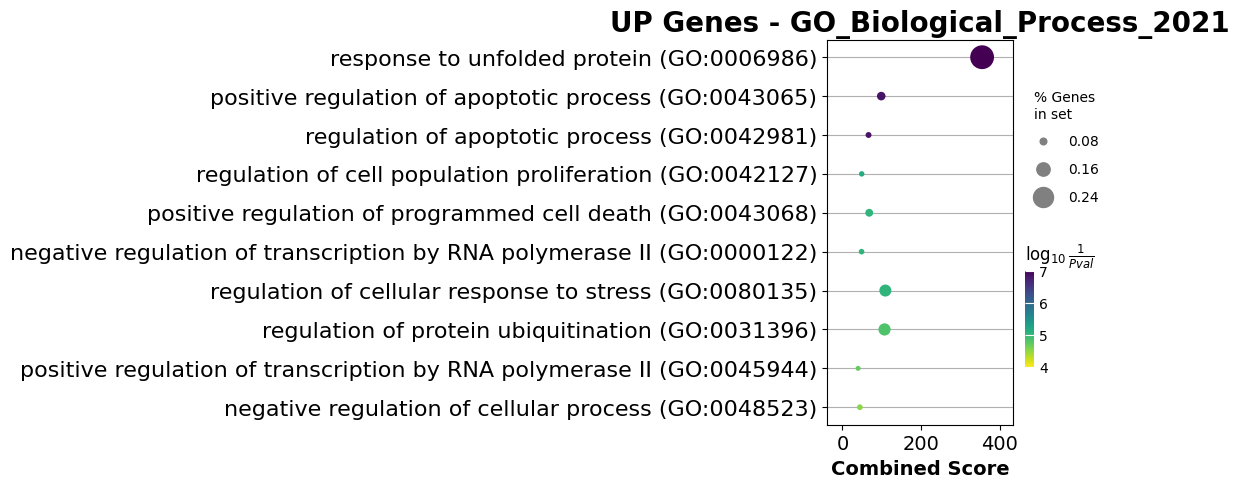

In [ ]:
dotplot(enr_up.res2d, title='UP Genes - GO_Biological_Process_2021',cmap='viridis_r', size=10, figsize=(3,5))

In [ ]:
# Down-regulated genes, cis vs untrt
enr_down = gp.enrichr(gene_list=gene_names_down,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='mouse',
                 outdir=None,
                )
enr_res_down = enr_down.results

enr_res_down.loc[enr_res_down['Adjusted P-value'] < .05]

Gene_set  \
0   GO_Biological_Process_2021   
1   GO_Biological_Process_2021   
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   
20  GO_Biological_Process_2021   
21  GO_Biological_Process_2021   
22  GO_Biological_Process_2021   
23  GO_Biological_Process_2021   
24  GO_Biological_Process_2021   
25  GO_Biological_Process_2021   
26  GO_Biological_Process_2021   
27  GO_Biological_Process_2021   
28  GO_Biological_Process_2021   
29  GO_Biological_Process_2021   
30  GO_Biological_Process_2021   
31  GO_Biological_Process_2021   
32  GO_Biological_Process_2021   
33  GO_Biological_Process_2021   
34  GO_Biological_Process_2021   
35  GO_Biological_Process_2021   
36  GO_Biological_Process_2021   
37  GO_Biological_Process_2021   
38  GO_Biological_Process_2021   
39  GO_Biological_Process_2021   
40  GO_Biological_Process_2021   
41  GO_Biological_Process_2021   
42  GO_Biological_Process_2021   

                                                 Term   Overlap       P-value  \
0                protein phosphorylation (GO:0006468)    40/496  2.126365e-07   
1   regulation of intracellular signal transductio...    36/437  5.216059e-07   
2   positive regulation of transcription, DNA-temp...   69/1183  3.098750e-06   
3   positive regulation of developmental process (...    19/177  6.706179e-06   
4   positive regulation of nucleic acid-templated ...    37/511  7.565072e-06   
5                    filopodium assembly (GO:0046847)      6/16  7.684084e-06   
6                        phosphorylation (GO:0016310)    31/400  1.104276e-05   
7   positive regulation of transcription by RNA po...    55/908  1.137842e-05   
8   transcription initiation from RNA polymerase I...    16/140  1.611991e-05   
9           regulation of cell migration (GO:0030334)    31/408  1.630148e-05   
10  regulation of small GTPase mediated signal tra...    16/141  1.763697e-05   
11   regulation of embryonic development (GO:0045995)      8/36  1.818743e-05   
12  plasma membrane bounded cell projection assemb...    24/278  1.906532e-05   
13  positive regulation of cell projection organiz...    14/117  3.223154e-05   
14    transcription by RNA polymerase II (GO:0006366)    25/320  6.764720e-05   
15           protein autophosphorylation (GO:0046777)    16/159  7.728236e-05   
16  regulation of plasma membrane bounded cell pro...     10/70  9.633124e-05   
17  positive regulation of lipid metabolic process...      6/25  1.317931e-04   
18      regulation of hydrolase activity (GO:0051336)     10/73  1.380581e-04   
19    positive regulation of JNK cascade (GO:0046330)     10/73  1.380581e-04   
20  regulation of transcription, DNA-templated (GO...  105/2244  1.420635e-04   
21  DNA-templated transcription, initiation (GO:00...    16/168  1.481011e-04   
22             regulation of JNK cascade (GO:0046328)    12/105  1.813571e-04   
23       cellular response to starvation (GO:0009267)    15/158  2.445511e-04   
24  negative regulation of transcription, DNA-temp...    52/948  2.472657e-04   
25  positive regulation of cell migration (GO:0030...    21/269  2.550079e-04   
26    regulation of dendrite development (GO:0050773)      7/39  2.552977e-04   
27  positive regulation of GTPase activity (GO:004...    18/214  2.814178e-04   
28  positive regulation of developmental growth (G...      8/52  2.840433e-04   
29         regulation of hippo signaling (GO:0035330)      5/20  3.984142e-04   
30  positive r

<Axes: title={'center': 'DOWN Genes - GO_Biological_Process_2021'}, xlabel='Combined Score'>

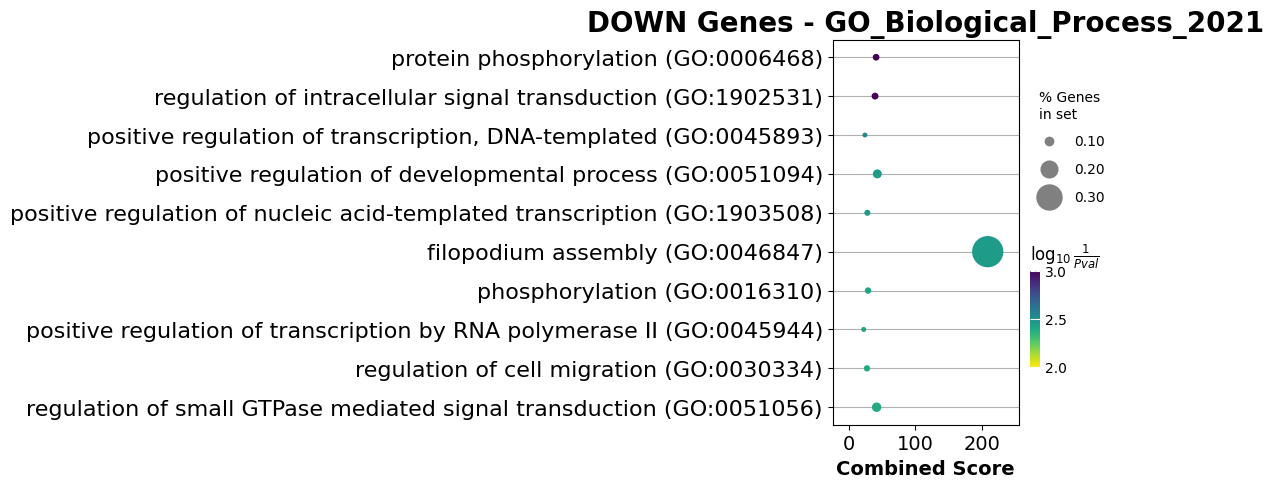

In [ ]:
dotplot(enr_down.res2d, title='DOWN Genes - GO_Biological_Process_2021',cmap='viridis_r', size=10, figsize=(3,5))


There is a high response to unfolded proteins from up-regulated genes. Down-regulated genes have : high response to filopodium assembly. Thus, it can be said that cisplatin treatment caused two distinct biological effects.

For down-regulated genes, specifically those related to the gene set "filopodium assembly." suggest that cisplatin treatment had an inhibitory effect on the assembly of filopodia. Filopodia are thin, finger-like protrusions on the cell surface involved in cell migration, adhesion, and signaling. The down-regulated genes associated with filopodium assembly implies that cisplatin treatment may have disrupted cellular processes involved in filopodia formation which can potentially impact cell movement and communication.

For up-regulated genes, the identified pathways can suggest the activation of specific cellular responses as a result of cisplatin treatment. These responses can be DNA damage response, cellular response to restore protein homeostasis, accumulation of unfolded or misfolded proteins or other responses that are stimulated by cisplatin.